<a href="https://colab.research.google.com/github/ronenfeldman/Practicum23/blob/main/yehonatan_cohen/using_re_3000_url.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install PyMuPDF

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 18.5 MB/s eta 0:00:00


In [ ]:
import requests
import os
import fitz  # PyMuPDF
import json
import re

# Function to download a PDF file from a URL
def download_pdf(url, filename):
    response = requests.get(url)
    with open(filename, 'wb') as output_file:
        output_file.write(response.content)

# Function to extract text from a PDF file
def extract_text_from_pdf(file_path):
    doc = fitz.open(file_path)
    text = ''
    for page in doc:
        text += page.get_text()  # changed from getText() to get_text()
    return text

# Function to split the text into paragraphs
def chunk_into_paragraphs(text, min_words=10):
    paragraphs = []
    current_paragraph = []
    for line in text.split('\n'):
        current_paragraph.append(line)
        if len(' '.join(current_paragraph).split()) >= min_words:
            paragraphs.append(' '.join(current_paragraph))
            current_paragraph = []
    return paragraphs

# Function to classify the paragraphs
def classify_paragraphs(paragraphs):
    future_tense_verbs = ["will", "is going to", "are going to", "aims to", "aim to", "plan to", "plans to"]
    past_tense_verbs = ["did", "had", "was", "were"]
    suggestive_words = ["suggests", "implies", "indicates"]

    classified_paragraphs = []

    for paragraph in paragraphs:
        category = "Other"

        # Check for numbers or percentages
        if re.search(r'\d', paragraph):
            # Check for absence of future-tense verbs
            if not any(verb in paragraph for verb in future_tense_verbs):
                category = "Quantitative Evidence"
        elif any(verb in paragraph for verb in past_tense_verbs):
            category = "Action Evidence"
        elif any(word in paragraph for word in suggestive_words):
            category = "Suggestive Evidence"
        elif any(verb in paragraph for verb in future_tense_verbs):
            category = "Intention"

        classified_paragraphs.append({"Paragraph": paragraph, "Category": category})

    return classified_paragraphs

# Load the list of URLs from the file
with open('PDF files.txt', 'r') as file:
    urls = [line.strip() for line in file]

# Limit the number of URLs to process
max_urls = 3000
urls = urls[:max_urls]

# Initialize an empty list to hold all the results
all_results = []

# Process each URL
for i, url in enumerate(urls):
    # Extract the name of the PDF file from the URL
    pdf_name = url.split('/')[-1]

    # Download the PDF file
    filename = f'pdf_file_{i}.pdf'
    download_pdf(url, filename)

    # Extract the text from the PDF file
    text = extract_text_from_pdf(filename)

    # Split the text into paragraphs
    paragraphs = chunk_into_paragraphs(text)

    # Classify the paragraphs
    classified_paragraphs = classify_paragraphs(paragraphs)

    # Add the results to the list of all results
    all_results.append({"PDF Name": pdf_name, "Classified Paragraphs": classified_paragraphs})

    # Delete the PDF file
    os.remove(filename)

# Save all the results to a single JSON file
with open('all_classified_paragraphs.json', 'w') as json_file:
    json.dump(all_results, json_file, indent=4)

In [ ]:
# Load the JSON data
with open('/content/all_classified_paragraphs.json') as json_file:
    data = json.load(json_file)

# Print the first item to check the structure of the data
# data[0]

Number of PDF files: 3000
Total number of paragraphs: 3863199
Number of paragraphs in each category: Counter({'Other': 2373446, 'Quantitative Evidence': 1307340, 'Action Evidence': 109071, 'Intention': 72545, 'Suggestive Evidence': 797})


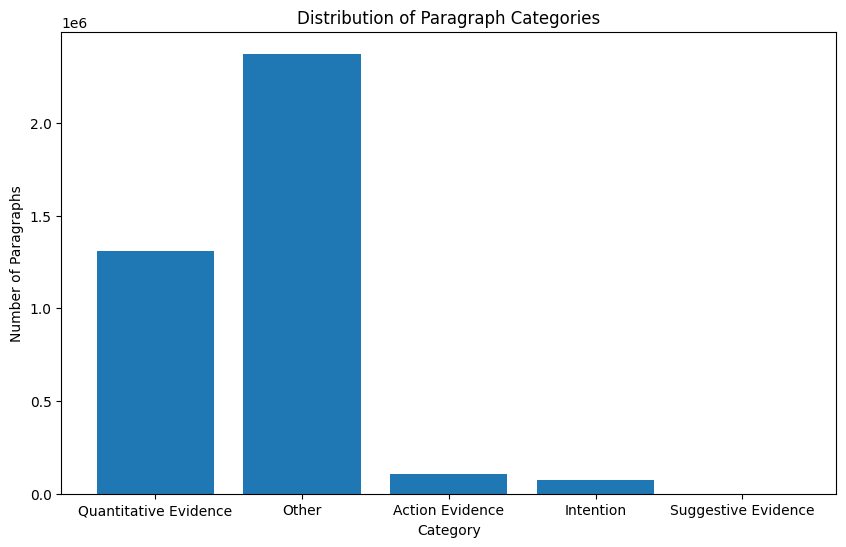

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

# Count the number of PDF files
num_pdfs = len(data)
print(f"Number of PDF files: {num_pdfs}")

# Initialize a counter for the categories
category_counter = Counter()

# Initialize a counter for the paragraphs
num_paragraphs = 0

# Process each PDF
for pdf in data:
    # Count the number of paragraphs
    num_paragraphs += len(pdf["Classified Paragraphs"])

    # Count the categories
    for paragraph in pdf["Classified Paragraphs"]:
        category_counter[paragraph["Category"]] += 1

print(f"Total number of paragraphs: {num_paragraphs}")
print(f"Number of paragraphs in each category: {category_counter}")

# Display the distribution of categories as a bar chart
plt.figure(figsize=(10, 6))
plt.bar(category_counter.keys(), category_counter.values())
plt.xlabel('Category')
plt.ylabel('Number of Paragraphs')
plt.title('Distribution of Paragraph Categories')
plt.show()